In [1]:
#Lectura de librerías
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

2024-03-12 00:27:37.562235: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-12 00:27:37.609219: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-12 00:27:40.696153: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#Lectura de datos
archivo_excel = '/workspace/Ejercicio4/data_customer_classification 1.xlsx'
datos = pd.read_excel(archivo_excel)

In [3]:
#Creación de nuevas variables
# Convertir la columna 'fecha' a tipo datetime
datos['trans_date'] = pd.to_datetime(datos['trans_date'])
# Calcular la frecuencia de compra de cada cliente
frecuencia_compra = datos.groupby('customer_id').size()
# Crear una nueva columna 'frecuencia_compra' en el DataFrame original
datos['frecuencia_compra'] = datos['customer_id'].map(frecuencia_compra)
# Calcular los hábitos de gasto de cada cliente (promedio de monto gastado por compra)
habitos_gasto = datos.groupby('customer_id')['tran_amount'].mean()
# Crear una nueva columna 'habitos_gasto' en el DataFrame original
datos['habitos_gasto'] = datos['customer_id'].map(habitos_gasto)
# Calcular la cantidad máxima que cada cliente gastó en la tienda
max_gasto = datos.groupby('customer_id')['tran_amount'].max()
# Crear una nueva columna 'max_gasto' en el DataFrame original
datos['max_gasto'] = datos['customer_id'].map(max_gasto)
# Crea la variable día, mes y año
# datos['dia'] = datos['trans_date'].dt.day
# datos['mes'] = datos['trans_date'].dt.month
# datos['año'] = datos['trans_date'].dt.year

In [4]:
#Creación del target
condiciones = [
    (datos['tran_amount'] >= 0) & (datos['tran_amount'] < 40),
    (datos['tran_amount'] >= 40) & (datos['tran_amount'] < 80),
    (datos['tran_amount'] >= 80)
]
valores = ['low', 'medium', 'high']
datos['target'] = np.select(condiciones, valores, default='OTROS')

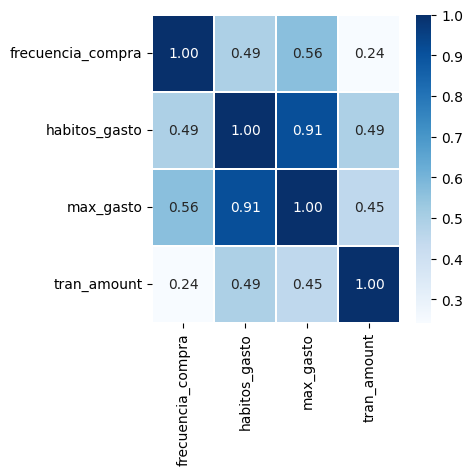

In [5]:
# Mapa de Correlación
import matplotlib.pyplot as plt
import seaborn as sns
import plotly 
columns_except_monto_prepagado = [col for col in datos.columns if col != 'tran_amount']
new_order = columns_except_monto_prepagado + ['tran_amount']
base_prepagos = datos.reindex(columns=new_order)
columnas_numericas = base_prepagos.select_dtypes(include=['number'])
correlacion = columnas_numericas.corr()
f, axx = plt.subplots(figsize=(4,4))
sns.heatmap(correlacion, linewidths=0.3, cmap="Blues", annot=True,fmt=".2f", ax=axx)
plt.show()

In [6]:
#Borrado de columnas no necesarias para el modelo 
datos = datos.drop(['customer_id', 'trans_date', 'tran_amount'], axis=1)

In [7]:
# Define target y covariables
X = datos.drop('target', axis=1)
y = datos['target'] 

In [8]:
# Convertir las etiquetas categóricas en valores numéricos
y_numerico, categorias = pd.factorize(y)
# Convertir los labels del target con one-hot encoding
y_encoded = to_categorical(y_numerico, num_classes=len(categorias))

# Splitting del dataset en train y validacion
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [9]:
# Estandizar y escalar las covariables
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.regularizers import l2

# Definición del modelo
model = Sequential([
    InputLayer(input_shape=(X_train.shape[1],)),  
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),  
    Dense(3, activation='relu'),
    Dense(3, activation='softmax') 
])

# Compilación del modelo
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [11]:
# Definir el nombre del archivo donde se guardará el mejor modelo
checkpoint_filepath = './best_model.keras'
#Entrenamiento y guardado vía callback del mejor modelo durante el entrenamiento
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)
#Entrenamiento del modelo con el callback para guardar el mejor modelo
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[model_checkpoint_callback]
)
#Cargar el mejor modelo guardado
best_model = load_model(checkpoint_filepath)
#Evaluación del mejor modelo
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print('Test Accuracy:', test_accuracy)

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5673 - loss: 0.8667
Epoch 1: val_accuracy improved from -inf to 0.57380, saving model to ./best_model.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.5673 - loss: 0.8667 - val_accuracy: 0.5738 - val_loss: 0.8238
Epoch 2/20
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5788 - loss: 0.8195
Epoch 2: val_accuracy did not improve from 0.57380
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.5788 - loss: 0.8195 - val_accuracy: 0.5719 - val_loss: 0.8234
Epoch 3/20
1556/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5783 - loss: 0.8183
Epoch 3: val_accuracy improved from 0.57380 to 0.57532, saving model to ./best_model.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.5783 - loss: 0.8183 - val_accuracy: 0.5753 - val_loss: 0.8219
Epoch 4/20
1561/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5770 - loss: 0.8207
Epoch 4: val_accuracy improved from 0.57532 to 0.57608, sa